# Training Notebook for BirdCLEF2023

## Import all Dependencies (1)

In [23]:
%pip install audiomentations


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
import torch
import torchvision
import torchaudio
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics
from tqdm import tqdm
import audiomentations as AA

import os
import sys
import random
import time
import copy
import logging
import bisect
import json
import shutil
import IPython.display as ipd

## Define a CONFIG class containing all relevant hyperparameters

In [25]:
class Config():
    def __init__(self) -> None:

        self.run_environment = 'kaggle' # 'kaggle' 'local' 'colab'
        self.load_pretrained_weights = False
        self.training_data_per_epoch = 1
        self.soft_second_label = 0.3
        self.class_weighting = False
        self.softmax_prob = True
        self.use_mixup = True
        self.mix_up_prob = 0.5
        self.criterion = 'LabelSmoothingBCEWithLogitsLoss' # 'BCEFocalLoss' # 'LabelSmoothingBCEWithLogitsLoss' # 'LabelSmoothingBCEWithLogitsLoss' # 'CrossEntropyLoss' # 'BCEWithLogitsLoss'
        self.epochs = 30
        self.masking = False
        self.masking_prob = 0.005
        self.frac_nocall = 0.01
        self.use_nocall = False
        self.addbackground_prob = 0.0
        self.uniform_sampler = False
        self.with_replacement_valid = False
        self.with_replacement_train = False
        self.analyze_dataset = False
        self.fix_features = False
        self.augment_audio_train = True

        # Device
        if (self.run_environment == 'kaggle') or (self.run_environment == 'colab'):
            self.device = 'cpu'
        else:
            self.device = 'cpu'
        
        # Dataset Path
        if self.run_environment == 'kaggle':
            self.dataset_swiss_birds_train = '/kaggle/input/swissbirds/swiss_birds/wav_files/train'
            self.dataset_swiss_birds_training_metadata = '/kaggle/input/swissbirds/swiss_birds/metadata_train.csv'
            self.birdclef2021_background_noise = '/kaggle/input/birdclef2021-background-noise/ff1010bird_nocall/nocall' 
            self.birdclef2021_background_noise_metadata = '/kaggle/input/birdclef2021-background-noise/ff1010bird_nocall/ff1010bird_metadata_v1.csv'
        elif self.run_environment == 'local':
            self.dataset_swiss_birds_train = '/home/colin/elec5305/ele5305_research_project/swiss_birds/wav_files/train'
            self.dataset_swiss_birds_training_metadata = '/home/colin/elec5305/ele5305_research_project/swiss_birds/metadata_train.csv'
            self.birdclef2021_background_noise = '/home/colin/elec5305/ele5305_research_project/birdclef2021_background_noise/ff1010bird_nocall/nocall' 
            self.birdclef2021_background_noise_metadata = '/home/colin/elec5305/ele5305_research_project/birdclef2021_background_noise/ff1010bird_nocall/ff1010bird_metadata_v1.csv'
        elif self.run_environment == 'colab':
            self.birdclef2023_melspectrograms = ''

        # Out path
        if self.run_environment == 'kaggle':
            self.outpath = '/kaggle/working/results'
        elif self.run_environment == 'local':
            self.outpath = 'results'
        elif self.run_environment == 'colab':
            self.outpath = ''
            
        if self.run_environment == 'kaggle':
            self.back1 = '/kaggle/input/birdclef2021-background-noise/ff1010bird_nocall/nocall'
            self.back2 = '/kaggle/input/birdclef2021-background-noise/train_soundscapes/nocall'
            self.back3 = '/kaggle/input/birdclef2021-background-noise/aicrowd2020_noise_30sec/noise_30sec'
        else:
            self.back1 = "/home/colin/elec5305/ele5305_research_project/birdclef2021_background_noise/ff1010bird_nocall/nocall"
            self.back2 = "/home/colin/elec5305/ele5305_research_project/birdclef2021_background_noise/train_soundscapes/nocall"
            self.back3 = "/home/colin/elec5305/ele5305_research_project/birdclef2021_background_noise/aicrowd2020_noise_30sec/noise_30sec"

        # Dataset Path
        if self.run_environment == 'kaggle':
            self.dataset_swiss_birds_test = '/kaggle/input/swissbirds/swiss_birds/wav_files/test'
            self.dataset_swiss_birds_test_metadata = '/kaggle/input/swissbirds/swiss_birds/metadata_test.csv'
        elif self.run_environment == 'local':
            self.dataset_swiss_birds_test = '/home/colin/elec5305/ele5305_research_project/swiss_birds/wav_files/test'
            self.dataset_swiss_birds_test_metadata = '/home/colin/elec5305/ele5305_research_project/swiss_birds/metadata_test.csv'
 
        # Train/Validation Split 
        self.val_frac = 0.1

        # Dataloader options
        self.num_workers = 4
        self.train_batch_size = 32
        self.valid_batch_size = 32
        self.test_batch_size = 4

        # Model name
        self.model_name = 'tf_efficientnet_b0.ns_jft_in1k'
        # Pretrained
        if self.run_environment == 'kaggle':
            self.pretrained_weights = '/kaggle/input/2023-11-09-14-03-57/model_weights.pth'
        elif self.run_environment == 'local':
            self.pretrained_weights = '/home/colin/elec5305/ele5305_research_project/weights/model_weights.pth'


        # Optimizer Settings
        self.lr=3e-4
        self.weight_decay = 1e-3
        self.momentum=0.9
        self.optimizer = 'adam' # 'adam', 'sgd'

        self.scheduler = 'cosineannealing'
        self.eta_min = 1e-6
        self.T_mult = 1
        self.last_epoch = -1

        self.mixup_alpha = 0.5

        # Training Settings
        self.print_every_n_batches = 25
        self.patience = 100

        # Image Transforms
        self.train_transforms = torchvision.transforms.Compose([
                    torchaudio.transforms.AmplitudeToDB(),
                    # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    torchvision.transforms.RandomResizedCrop(size=(80,78), scale = (0.75, 1.0), antialias=True), 
                    ])
        
        self.val_transforms = torchvision.transforms.Compose([
                    torchaudio.transforms.AmplitudeToDB(),
                    # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    torchvision.transforms.Resize(size=[80,78], antialias=True),
                    # torchvision.transforms.RandomResizedCrop(size=(128, 312), scale = (0.75, 1.0), antialias=True), 
                    ])
        
        self.test_transforms = torchvision.transforms.Compose([
                    torchaudio.transforms.AmplitudeToDB(),
                    torchvision.transforms.Resize(size=[80,78], antialias=True),
                    ])
        
        # https://github.com/AtsunoriFujita/BirdCLEF-2023-Identify-bird-calls-in-soundscapes/blob/main/src/train_net.py
        if self.augment_audio_train == True:
            self.train_transforms_audio = AA.Compose(
                                            [
                                                AA.OneOf([
                                                    AA.Gain(min_gain_in_db=-15, max_gain_in_db=15, p=1.0),
                                                    AA.GainTransition(
                                                        min_gain_in_db=-24.0,
                                                        max_gain_in_db=6.0,
                                                        min_duration=0.2,
                                                        max_duration=6.0,
                                                        p=1.0
                                                    )
                                                ], p=0.5,),
                                                AA.OneOf([
                                                    AA.AddGaussianNoise(p=1.0),
                                                    AA.AddGaussianSNR(p=1.0),
                                                ], p=0.3,),
                                                AA.OneOf([
                                                    AA.AddShortNoises(
                                                        sounds_path=self.back1,
                                                        min_snr_in_db=0,
                                                        max_snr_in_db=3,
                                                        p=1.0,
                                                        lru_cache_size=10,
                                                        min_time_between_sounds=4.0,
                                                        max_time_between_sounds=16.0,
                                                    ),
                                                ], p=0.5,),
                                                AA.OneOf([
                                                    AA.AddBackgroundNoise(
                                                        sounds_path=self.back2,
                                                        min_snr_in_db=0,
                                                        max_snr_in_db=3,
                                                        p=1.0,
                                                        lru_cache_size=3,),
                                                    AA.AddBackgroundNoise(
                                                        sounds_path=self.back3,
                                                        min_snr_in_db=0,
                                                        max_snr_in_db=3,
                                                        p=1.0,
                                                        lru_cache_size=450,),
                                                ], p=0.5,),
                                                AA.LowPassFilter(p=0.5),
                                            ]
                                        )
        else:
            self.train_transforms_audio = None
                                            
        self.val_transforms_audio = None
        
        self.test_transforms_audio = None


        # Audio Features
        self.sample_rate = 32000
        self.period = 5

        # Mel Spectrogram Parameters
        self.n_fft=2048
        self.f_min=40
        self.f_max=15000
        self.hop_length=1024
        self.n_mels=80
        self.mel_args = {'n_fft': self.n_fft,
                         'f_min': self.f_min,
                         'f_max': self.f_max,
                         'hop_length': self.hop_length,
                         'n_mels': self.n_mels}
        
        
        if self.run_environment == 'colab':
            from google.colab import drive
            drive.mount('/content/drive')

            notebook_path = 'My Drive/elec5305'

            env_path = f'/content/drive/{notebook_path}'
            # Add the handout folder to python paths
            if env_path not in sys.path:
                sys.path.append(env_path)

            # zip_path = os.path.join(env_path, 'birdclef-2023_MelSpectrograms.zip')
            zip_path = '/content/drive/MyDrive/elec5305/birdclef-2023_MelSpectrograms.zip'
            shutil.unpack_archive(zip_path, "content/")
            print(zip_path)
            # !unzip zip_path -d "/content"

            # Dataset path
            self.birdclef2023_melspectrograms = '/content/content/birdclef-2023_MelSpectrograms'

            # Output path
            self.outpath = os.path.join(env_path, 'results')
            os.makedirs(self.outpath, exist_ok=True)# !pip install --force-reinstall numpy==1.22.1
            
            %pip install -q torchtoolbox timm

            %pip install timm torchtoolbox

        if self.run_environment != 'local':
            # !pip install --force-reinstall numpy==1.22.1
            %pip install -q torchtoolbox timm
            
        self.species_list = ['Song Thrush', 'Common Chaffinch', 'European Robin', 'Yellowhammer', 'Eurasian Wren', 'Common Nightingale', "Western Bonelli's Warbler", 'Common Redstart', 'Red Crossbill', 'Garden Warbler', 'Black Redstart', 'Tree Pipit', 'Marsh Warbler', 'Great Spotted Woodpecker', 'Tawny Owl', 'Common Blackbird', 'Willow Tit', 'Eurasian Eagle-Owl', 'Great Tit', 'Eurasian Blackcap', 'Common Chiffchaff', 'Eurasian Coot', 'Eurasian Reed Warbler', 'Yellow-legged Gull', 'Coal Tit']
        
CONFIG = Config()

## Import all dependencies (2)

In [26]:
from torchtoolbox.tools import mixup_data, mixup_criterion
from torch.nn.functional import cross_entropy
import timm

## Define Network

In [27]:
class MelSpectrogramLayer(nn.Module):
    def __init__(self, sample_rate, n_fft, hop_length, n_mels, transform, config):
        super(MelSpectrogramLayer, self).__init__()
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )
        self.transform = transform
        self.config = config

    def forward(self, waveform):

        mel_spectrogram = self.mel_transform(waveform)

        batched = True
        if mel_spectrogram.dim() == 2:
            batched = False
        elif mel_spectrogram.dim() == 3:
            batched = True

        if batched == True:
            if self.training and torch.rand(1) >= self.config.masking_prob and self.config.masking == True:
                mel_spectrogram = torchaudio.transforms.FrequencyMasking(
                    freq_mask_param=mel_spectrogram.shape[1] // 5
                )(mel_spectrogram)
                mel_spectrogram = torchaudio.transforms.TimeMasking(
                    time_mask_param=mel_spectrogram.shape[2] // 5
                )(mel_spectrogram)
        else:
            if self.training and torch.rand(1) >= self.config.masking_prob and self.config.masking == True:
                mel_spectrogram = torchaudio.transforms.FrequencyMasking(
                    freq_mask_param=mel_spectrogram.shape[0] // 5
                )(mel_spectrogram)
                mel_spectrogram = torchaudio.transforms.TimeMasking(
                    time_mask_param=mel_spectrogram.shape[1] // 5
                )(mel_spectrogram)


        if batched == True:
            mel_spectrogram = mel_spectrogram.unsqueeze(1)
            mel_spectrogram = mel_spectrogram.expand(-1, 3, -1, -1)
        else:
            mel_spectrogram = mel_spectrogram.unsqueeze(0)
            mel_spectrogram = mel_spectrogram.expand(3, -1, -1)

        mel_spectrogram = self.transform(mel_spectrogram)

        mel_spectrogram = torch.nan_to_num(mel_spectrogram)

        mel_spectrogram = self.normalize(mel_spectrogram)
        
        return mel_spectrogram
    
    def normalize(self, image):
        mel_spectrogram = (image - image.min()) / ( image.max() - image.min())
        return mel_spectrogram


#####################################3
    

# https://www.kaggle.com/code/leonshangguan/faster-eb0-sed-model-inference

def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def init_weights(model):
    classname = model.__class__.__name__
    if classname.find("Conv2d") != -1:
        nn.init.xavier_uniform_(model.weight, gain=np.sqrt(2))
        model.bias.data.fill_(0)
    elif classname.find("BatchNorm") != -1:
        model.weight.data.normal_(1.0, 0.02)
        model.bias.data.fill_(0)
    elif classname.find("GRU") != -1:
        for weight in model.parameters():
            if len(weight.size()) > 1:
                nn.init.orghogonal_(weight.data)
    elif classname.find("Linear") != -1:
        model.weight.data.normal_(0, 0.01)
        model.bias.data.zero_()



class AttBlockV2(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear"):
        super().__init__()

        self.activation = activation
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.tanh(self.att(x)), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

class Mel_Classifier(torch.nn.Module):
    def __init__(
        self, 
        model_name: str,
        mel_generator: MelSpectrogramLayer,
        # config=None,
        pretrained=True, 
        num_classes=25, 
        in_channels=3
    ):
        super().__init__()
        
        self.mel_generator = mel_generator

        base_model = timm.create_model(
            model_name, 
            pretrained=pretrained, 
            num_classes=0,
            global_pool="",
            in_chans=in_channels,
        )
        
        layers = list(base_model.children())[:-2]
        self.backbone = nn.Sequential(*layers)

        in_features = base_model.num_features

        self.fc1 = nn.Linear(in_features, in_features, bias=True)
        self.att_block = AttBlockV2(
            in_features, num_classes, activation="linear")

        self.init_weight()

    def init_weight(self):
        # init_bn(self.bn0)
        init_layer(self.fc1)
        
    def forward(self, x):
        x = self.mel_generator(x)

        x = self.backbone(x)
        
        # Aggregate in frequency axis
        x = torch.mean(x, dim=2)

        x1 = torch.nn.functional.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = torch.nn.functional.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2

        x = x.transpose(1, 2)
        x = torch.nn.functional.relu_(self.fc1(x))
        x = x.transpose(1, 2)

        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)

        # return output_dict
        return clipwise_output    

## Create a Dataset Class

### SwissBirds Dataset

In [28]:
class SwissBirds(torch.nn.Module):
    def __init__(self, datapath: list, metadata_df, audio_transforms, sample_rate, config, period, soft_second_label, inherited_species_list = None, backgroundData = None, *args, **kwargs) -> None:
        super().__init__()

        # Default values
        self.sample_rate = sample_rate
        self.audio_transforms = audio_transforms
        self.period = period
        self.config = config

        self.backgroundData = backgroundData

        self.df = metadata_df
        self.datapath = datapath

        self.soft_second_label = soft_second_label

        if len(self.datapath) == 2:
            self.audio_paths = [self.datapath[0], self.datapath[1]]
        else:
            self.audio_paths = [self.datapath[0]]

        # Get species list
        if inherited_species_list is None:
            self.species = list(set(self.df['en']))
        else:
            self.species = inherited_species_list

        return

    def __len__(self):
        # length = self.df['cumulative_images'][-1]
        length = len(list(self.df['en']))
        return length


    def __getitem__(self, idx):

        # Get row in df
        dict_idx = dict(self.df.iloc[idx])

        # Get labels as torch tensors
        primary_label = torch.tensor([1 if dict_idx['en'] == label else 0 for label in self.species],dtype=float)

        # Load audio
        if dict_idx['en'] == 'nocall':
            idx_dataset = 1
        else:
            idx_dataset = 0
        ogg_file = os.path.join(self.audio_paths[idx_dataset],dict(self.df.iloc[idx])['filename'])
        waveform, sample_rate = torchaudio.load(ogg_file)
        waveform = waveform.ravel()

        # Get clip of length self.period
        target_audio_length = sample_rate * self.period
        current_audio_length = len(waveform)
        if current_audio_length > target_audio_length:
            start = random.randint(0,current_audio_length - target_audio_length - 1)
            waveform_seg = waveform[start:start+target_audio_length]
        else:
            padding_length = target_audio_length - current_audio_length
            waveform_seg = torch.nn.functional.pad(waveform, (0, padding_length), 'constant', 0)

        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.sample_rate)
        waveform_seg = resampler(waveform_seg)

        if random.uniform(0,1) > self.config.addbackground_prob and self.backgroundData is not None:
            idx = random.randint(0,len(self.backgroundData)-1)
            backgroundNoise = self.backgroundData[idx][0]
            waveform_seg += backgroundNoise * 0.2

        # Apply transform
        if self.audio_transforms is not None:
            waveform_seg = self.audio_transforms(
                samples=waveform_seg.detach().numpy(), sample_rate=self.config.sample_rate
                )
            
        if isinstance(waveform_seg, np.ndarray):
                waveform_seg = torch.from_numpy(waveform_seg)

        return waveform_seg, primary_label

### No Call Dataset

In [29]:
class NoCallDataset(torch.nn.Module):
    def __init__(self, datapath, metadata_df, audio_transforms, sample_rate, period, inherited_species_list=None, *args, **kwargs) -> None:

        # Default values
        self.sample_rate = sample_rate
        self.audio_transforms = audio_transforms
        self.period = period

        self.df = metadata_df
        self.datapath = datapath

        self.soft_second_label = 0

        self.audio_paths = [0, self.datapath[1]]


        # Get species list
        if inherited_species_list is None:
            self.species = list(set(self.df['en']))
        else:
            self.species = inherited_species_list

        return
    
    def __len__(self):
        # length = self.df['cumulative_images'][-1]
        length = len(list(self.df['en']))
        return length


    def __getitem__(self, idx):

        # Get row in df
        dict_idx = dict(self.df.iloc[idx])

        # Get labels as torch tensors
        primary_label = torch.tensor([1 if dict_idx['en'] == label else 0 for label in self.species],dtype=float)
        secondary_label = torch.tensor([1 if label in dict_idx['secondary_labels'] else 0 for label in self.species], dtype=float)
        combined_label = self._prepare_target(main_tgt=primary_label, sec_tgt=secondary_label)
        dict_idx['combined_label_tensor'] = combined_label
        dict_idx['primary_label_tensor'] = primary_label
        dict_idx['secondary_label_tensor'] = secondary_label

        # Load audio
        if dict_idx['en'] == 'nocall':
            idx_dataset = 1
        else:
            idx_dataset = 0
        ogg_file = os.path.join(self.audio_paths[idx_dataset],dict(self.df.iloc[idx])['filename'])
        waveform, sample_rate = torchaudio.load(ogg_file)
        waveform = waveform.ravel()

        # Get clip of length self.period
        target_audio_length = sample_rate * self.period
        current_audio_length = len(waveform)
        if current_audio_length > target_audio_length:
            start = random.randint(0,current_audio_length - target_audio_length - 1)
            waveform_seg = waveform[start:start+target_audio_length]
        else:
            padding_length = target_audio_length - current_audio_length
            waveform_seg = torch.nn.functional.pad(waveform, (0, padding_length), 'constant', 0)

        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.sample_rate)
        waveform_seg = resampler(waveform_seg)

        return waveform_seg, combined_label

    # https://github.com/VSydorskyy/BirdCLEF_2023_1st_place/blob/main/code_base/datasets/wave_dataset.py, changed
    def _prepare_target(self, main_tgt, sec_tgt, all_labels=None):
        all_tgt = main_tgt + sec_tgt * self.soft_second_label
        all_tgt = torch.clamp(all_tgt, 0.0, 1.0)
        return all_tgt

### Make Train / Valid Split

In [30]:
# https://www.kaggle.com/code/nischaydnk/split-creating-melspecs-stage-1
def birds_stratified_split(df, target_col, test_size=0.2):
    class_counts = df[target_col].value_counts()
    low_count_classes = class_counts[class_counts < 2].index.tolist() ### Birds with single counts

    df['train'] = df[target_col].isin(low_count_classes)

    train_df, val_df = train_test_split(df[~df['train']], test_size=test_size, stratify=df[~df['train']][target_col], random_state=42)

    train_df = pd.concat([train_df, df[df['train']]], axis=0).reset_index(drop=True)

    # Remove the 'valid' column
    train_df.drop('train', axis=1, inplace=True)
    val_df.drop('train', axis=1, inplace=True)

    return train_df, val_df

## Uniform Sampler

In [31]:
def make_uniformSampler(dataset, config, replacement = True):
    classes_lsit = dataset.species

    count_int = [0] * len(classes_lsit)
    count_int_frame = [0] * len(classes_lsit)
    nocall_count = 0

    # Get class counts
    for i in range(len(dataset)):
        if dataset.df.iloc[i]['en'] == 'nocall':
            nocall_count += 1
        else:
            species_index = classes_lsit.index(dataset.df.iloc[i]['en'])
            count_int[species_index] += 1
            count_int_frame[species_index] += dataset.df.iloc[i]['length']

    # Calculate class weights
    n_recs = sum(count_int)
    n_frames = sum(count_int_frame)
    n_nocall = nocall_count

    # Consider if no nocall samples
    if n_nocall == 0:
        # n_nocall = 1
        loc_frac_nocall = 0
    else:
        loc_frac_nocall = config.frac_nocall

    sample_weights = [0] * len(dataset)

    no_call_sum = 0
    call_sum = 0

    prob_per_class = 1 / len(dataset.df['en'].unique().tolist())


    # Sample weights not considering recording length
    for i in range(len(dataset)):
        if dataset.df.iloc[i]['en'] == 'nocall':
            sample_weights[i] = 1 / n_nocall
            no_call_sum += sample_weights[i]
        else:
            species_index = classes_lsit.index(dataset.df.iloc[i]['en'])
            sample_weights[i] = ( prob_per_class / count_int[species_index] )


    # Modify weights to consider recording length
    for i in range(len(dataset)):
        if dataset.df.iloc[i]['en'] == 'nocall':
            pass
        else:
            species_index = classes_lsit.index(dataset.df.iloc[i]['en'])
            sample_weights[i] = sample_weights[i]  * ( dataset.df.iloc[i]['length'] / count_int_frame[species_index] ) * count_int[species_index]

    # Normalize
    for i in range(len(dataset)):
        if dataset.df.iloc[i]['en'] == 'nocall':
            sample_weights[i] = sample_weights[i] * loc_frac_nocall
            # sample_weights[i] = sample_weights[i] / no_call_sum * loc_frac_nocall
        else:
            sample_weights[i] = sample_weights[i] * (1 - loc_frac_nocall)
            # sample_weights[i] = sample_weights[i] / call_sum * (1 - loc_frac_nocall)

    # Create sampler
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(dataset), replacement=replacement)

    return sampler

In [32]:
def make_class_weights(dataset, focus = 'prevalence'):
    if focus == 'prevalence':
        n_data = len(dataset)
        classes_lsit = dataset.species

        count_int = [0] * len(classes_lsit)
        nocall_count = 0

        for i in range(len(dataset)):
            if dataset.df.iloc[i]['en'] == 'nocall':
                nocall_count += 1
            else:
                species_index = classes_lsit.index(dataset.df.iloc[i]['en'])
                count_int[species_index] += 1

        n_call = sum(count_int)
        class_weights = (np.array(count_int) / n_call) ** -0.5   * len(classes_lsit)

    else:
        class_weights = [0] * len(dataset)

        class_weights = np.array(dataset.df['rating'].tolist())

    return class_weights

## Make Datasets and Dataloaders

In [33]:
def make_dataset(config):
    # Load dataframe
    df = pd.read_csv(config.dataset_swiss_birds_training_metadata)

    # Get Split
    train_df, val_df = birds_stratified_split(df=df, target_col='en', test_size=config.val_frac)

    # Get global species list
    species_list = config.species_list

    # Initialize Datasets
    train_class_kwargs = {  'sample_rate': config.sample_rate,
                            'n_fft': config.n_fft,
                            'f_min': config.f_min,
                            'f_max': config.f_max,
                            'hop_length': config.hop_length,
                            'n_mels': config.n_mels,
                            'period': config.period,
                            'device': config.device,
                            'transform': config.train_transforms,
                            'soft_second_label': config.soft_second_label
                        }

    valid_class_kwargs = {   'sample_rate': config.sample_rate,
                            'n_fft': config.n_fft,
                            'f_min': config.f_min,
                            'f_max': config.f_max,
                            'hop_length': config.hop_length,
                            'n_mels': config.n_mels,
                            'period': config.period,
                            'device': config.device,
                            'transform': config.val_transforms
                        }

    #Make No Call Dataframes
    df_nocall = pd.read_csv(config.birdclef2021_background_noise_metadata)
    # Rename columns 
    df_nocall = df_nocall.rename(columns={'primary_label': 'en', 'recordings_lengths': 'length'})
    # Split
    df_train_nocall, df_valid_nocall = train_test_split(df_nocall, test_size=config.val_frac)


    # Concatenate dataframes
    df_train_full = pd.concat([train_df, df_train_nocall], axis = 0)
    df_valid_full = pd.concat([val_df, df_valid_nocall], axis = 0)

    # Reset the index to create a new index for the concatenated DataFrame
    df_train_full.reset_index(drop=True, inplace=True)
    df_valid_full.reset_index(drop=True, inplace=True)

    # Make Datasets
    train_dataset_nocall = NoCallDataset(datapath=[0,config.birdclef2021_background_noise], metadata_df=df_train_nocall, audio_transforms=config.train_transforms_audio, sample_rate=config.sample_rate, period=config.period, inherited_species_list=species_list)
    valid_dataset_nocall = NoCallDataset(datapath=[0,config.birdclef2021_background_noise], metadata_df=df_valid_nocall, audio_transforms=config.val_transforms_audio, sample_rate=config.sample_rate, period=config.period, inherited_species_list=species_list)

    # Make dataset
    if config.use_nocall == True:
        train_dataset = SwissBirds(datapath=[config.dataset_swiss_birds_train, config.birdclef2021_background_noise], config=config, metadata_df=df_train_full, audio_transforms=config.train_transforms_audio ,sample_rate=config.sample_rate, soft_second_label=config.soft_second_label, period=config.period, inherited_species_list=species_list)
        valid_dataset = SwissBirds(datapath=[config.dataset_swiss_birds_train, config.birdclef2021_background_noise], config=config, metadata_df=df_valid_full, audio_transforms=config.val_transforms_audio, sample_rate=config.sample_rate, soft_second_label=config.soft_second_label, period=config.period, inherited_species_list=species_list)
    else:
        train_dataset = SwissBirds(datapath=[config.dataset_swiss_birds_train], metadata_df=train_df, config=config, audio_transforms=config.train_transforms_audio ,sample_rate=config.sample_rate, soft_second_label=config.soft_second_label, period=config.period, inherited_species_list=species_list, backgroundData=train_dataset_nocall)
        valid_dataset = SwissBirds(datapath=[config.dataset_swiss_birds_train], metadata_df=val_df, config=config, audio_transforms=config.val_transforms_audio, sample_rate=config.sample_rate, soft_second_label=config.soft_second_label, period=config.period, inherited_species_list=species_list, backgroundData=valid_dataset_nocall)


    if config.uniform_sampler == False:
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset,num_workers=config.num_workers, batch_size=config.train_batch_size, shuffle = True, pin_memory = True)
        valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,num_workers=config.num_workers, batch_size=config.valid_batch_size, shuffle = True, pin_memory = True)
    else:
        train_sampler = make_uniformSampler(dataset=train_dataset, config=config, replacement = config.with_replacement_train)
        valid_sampler = make_uniformSampler(dataset=valid_dataset, config=config, replacement = config.with_replacement_valid)
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset,num_workers=config.num_workers, batch_size=config.train_batch_size, pin_memory = True, sampler=train_sampler)
        valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,num_workers=config.num_workers, batch_size=config.valid_batch_size, pin_memory = True, sampler=valid_sampler)

    return train_loader, valid_loader

## Define Metric Function as on Kaggle

In [34]:
def padded_cmap(solution, submission, padding_factor=5):
    solution = solution.drop(['row_id'], axis=1, errors='ignore')
    submission = submission.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

## Define Loss function

In [35]:
class LabelSmoothingBCEWithLogitsLoss(nn.Module):
    def __init__(self, smooth_eps=0.0025, weight=None, reduction="mean"):
        super(LabelSmoothingBCEWithLogitsLoss, self).__init__()
        self.smooth_eps = smooth_eps
        self.weight = weight
        self.reduction = reduction
        self.bce_with_logits_loss = nn.BCEWithLogitsLoss(weight=self.weight, reduction=self.reduction)

    def forward(self, input, target):
        target_smooth = torch.clamp(target.float(), self.smooth_eps, 1.0 - self.smooth_eps)
        target_smooth = target_smooth + (self.smooth_eps / target.size(1))
        return self.bce_with_logits_loss(input, target_smooth)
    
class BCEFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0,weight = None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight

    def forward(self, preds, targets):
        bce_loss = nn.BCEWithLogitsLoss(weight=self.weight, reduction='none')(preds, targets)
        probas = torch.sigmoid(preds)
        loss = targets * self.alpha * \
            (1. - probas)**self.gamma * bce_loss + \
            (1. - targets) * probas**self.gamma * bce_loss
        loss = loss.mean()
        return loss
    
class FocalLoss(torch.nn.Module):
    def __init__(
        self,
        alpha: float = 0.25,
        gamma: float = 2,
        reduction: str = "mean",
    ):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        return torchvision.ops.focal_loss.sigmoid_focal_loss(
            inputs=inputs,
            targets=targets,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction,
        )

## Define Training Function

In [36]:
class Mixup(nn.Module):
    def __init__(self, mix_beta):

        super(Mixup, self).__init__()
        self.beta_distribution = torch.distributions.Beta(mix_beta, mix_beta)

    def forward(self, X, Y, weight=None, teacher_preds=None):

        bs = X.shape[0]
        n_dims = len(X.shape)
        perm = torch.randperm(bs)
        coeffs = self.beta_distribution.rsample(torch.Size((bs,))).to(X.device)

        if n_dims == 2:
            X = coeffs.view(-1, 1) * X + (1 - coeffs.view(-1, 1)) * X[perm]
        elif n_dims == 3:
            X = coeffs.view(-1, 1, 1) * X + (1 - coeffs.view(-1, 1, 1)) * X[perm]
        else:
            X = coeffs.view(-1, 1, 1, 1) * X + (1 - coeffs.view(-1, 1, 1, 1)) * X[perm]

        Y = coeffs.view(-1, 1) * Y + (1 - coeffs.view(-1, 1)) * Y[perm]

        if weight is None:
            return X, Y
        else:
            weight = coeffs.view(-1) * weight + (1 - coeffs.view(-1)) * weight[perm]
            teacher_preds = coeffs.view(-1, 1) * teacher_preds + (1 - coeffs.view(-1, 1)) * teacher_preds[perm]
            return X, Y, weight, teacher_preds
        
def train_net(net, trainloader, valloader, criterion, optimizer, scheduler, config, epochs=1, patience = 3, savePth = 'project2_weights.pth', print_every_samples = 20, device = 'cpu'):

    mixup = Mixup(mix_beta=1)

    print('Using device: {}'.format(device))
    net.to(device)
    criterion.to(device)

    if config.softmax_prob == True:
        toProb = torch.nn.Softmax(dim=1)
    else:
        toProb = torch.nn.Identity()

    validation_loss_list = [0] * epochs
    training_loss_list = [0] * epochs
    validation_accuracy_list = [0] * epochs
    training_accuracy_list = [0] * epochs
    cmap_5_list = [0] * epochs

    best_state_dictionary = None
    best_validation_cmap = 0.0
    inertia = 0
    for epoch in range(epochs):

        training_loss = 0.0
        training_accuracy = 0.0
        running_loss = 0.0
        # Set model to training mode
        net.mel_generator.transform = config.train_transforms
        net = net.train()

        # Calculate the number of batches to loop over
        num_batches_to_loop = int(config.training_data_per_epoch * len(trainloader))
        with tqdm(enumerate(trainloader, 0), total=num_batches_to_loop, desc="Training Batches Epoch {} / {}".format(epoch + 1, epochs)) as train_pbar:
            for i, data in train_pbar:
        
                # get the inputs
                if device == 'cuda':
                    inputs, labels = data[0].to(device), data[1].to(device)
                else:
                    inputs, labels = data[0], data[1]

                # zero the parameter gradients
                optimizer.zero_grad()

                # mixup data
                if np.random.random() <= config.mix_up_prob:
                    inputs, labels = mixup(inputs, labels)

                # forward + backward + optimize
                outputs = net(inputs)

                loss_value = criterion((outputs),labels)

                loss_value.backward()
                optimizer.step()

                # print statistics and write to log
                running_loss += loss_value.item()
                training_loss += loss_value.item()

                train_pbar.set_postfix(loss=(running_loss / ((i + 1) * trainloader.batch_size)))
                training_accuracy += (outputs.argmax(1) == labels.argmax(1)).sum().item()

                if type(scheduler).__name__ != 'NoneType':
                    scheduler.step(epoch + i / len(trainloader))

                if i >= num_batches_to_loop:
                    break

        training_loss = training_loss / (len(trainloader.dataset) * config.training_data_per_epoch)
        training_loss_list[epoch] = training_loss
        training_accuracy = 100 * training_accuracy / (len(trainloader.dataset) * config.training_data_per_epoch)
        training_accuracy_list[epoch] = training_accuracy

        print('Batch {:5d} / {:5d}: Training Loss = {:.3f}, Training Accuracy = {:.3f}'.format(epoch + 1, epochs, training_loss, training_accuracy))

        running_loss = 0.0
        val_loss = 0.0
        correct = 0
        predictions_array = np.zeros((len(valloader.dataset), len(valloader.dataset.species)), dtype=float)
        solutions_array = np.zeros((len(valloader.dataset), len(valloader.dataset.species)), dtype=float)
        # Set model to validation mode
        net.mel_generator.transform = config.val_transforms
        net = net.eval()
        with tqdm(enumerate(valloader, 0), total=len(valloader), desc="Validation Batches Epoch {} / {}".format(epoch + 1, epochs)) as val_pbar:
            for i, data in val_pbar:
                # get the inputs
                if device == 'cuda':
                    inputs, labels = data[0].to(device), data[1].to(device)
                else:
                    inputs, labels = data[0], data[1]
                    
                # forward + backward + optimize
                outputs = net(inputs)
                loss_value = criterion(outputs, labels)

                # print statistics and write to log
                running_loss += loss_value.item()
                val_loss += loss_value.item()

                # Get model output and label to array
                curr_predictions_array = toProb(outputs).detach().cpu().numpy()
                predictions_array[i*valloader.batch_size:(i+1)*valloader.batch_size,:] = curr_predictions_array
                hardlabels = labels.detach().cpu().numpy()
                hardlabels[hardlabels < 0.99] = 0
                curr_solutions_array = hardlabels
                solutions_array[i*valloader.batch_size:(i+1)*valloader.batch_size,:] = curr_solutions_array

                # Update progress bar
                val_pbar.set_postfix(loss=(running_loss / ((i + 1) * trainloader.batch_size)))
                correct += (outputs.argmax(1) == labels.argmax(1)).sum().item()
        
        # Get cMAP
        cmap_5 = padded_cmap(solution=pd.DataFrame(solutions_array), submission=pd.DataFrame(predictions_array), padding_factor=5)

        # Get Metrics
        val_loss = val_loss / len(valloader.dataset)
        validation_loss_list[epoch] = val_loss
        val_accuracy = 100 * correct / len(valloader.dataset)
        validation_accuracy_list[epoch] = val_accuracy
        cmap_5_list[epoch] = cmap_5

        print('Batch {:5d} / {:5d}: Validation Loss = {:.3f}, Validation Accuracy = {:.3f}, cmap score = {:.3f}'.format(epoch + 1, epochs, val_loss, val_accuracy, cmap_5))

        save_weights = os.path.join(savePth,'model_weights.pth')
        if cmap_5 > best_validation_cmap:
            best_validation_cmap = cmap_5
            best_state_dictionary = copy.deepcopy(net.state_dict())
            # save network
            torch.save(best_state_dictionary, save_weights)
            inertia = 0
            print('Epoch {:5d} / {:5d} saved: New Best Epoch!'.format(epoch + 1, epochs))
        else:
            inertia += 1
            if inertia == patience:
                if best_state_dictionary is None:
                    raise Exception("State dictionary should have been updated at least once")
                break
        # print(f"Validation accuracy: {val_accuracy}")

    print('Finished Training')

    output = {'validation_loss': validation_loss_list,
              'validation_accuracy': validation_accuracy_list,
              'training_loss': training_loss_list,
              'training_accuracy': training_accuracy_list,
              'cmap_5_scores': cmap_5_list}
    
    return output

In [37]:
def get_model(config):
    melspec_layer = MelSpectrogramLayer(sample_rate=config.sample_rate,
                                    n_fft=config.n_fft,
                                    hop_length=config.hop_length,
                                    config=config,
                                    n_mels=config.n_mels,
                                    transform=config.train_transforms)
    network = Mel_Classifier(model_name=config.model_name,
                            mel_generator=melspec_layer)
    
    if config.load_pretrained_weights == True:
        print('Load PreTrained Weigths')
        network.load_state_dict(torch.load(config.pretrained_weights, map_location=config.device))

    if config.fix_features == True:
        for param in network.backbone.parameters():
            param.requires_grad = False
    
    return network

def get_criterion(config, train_dataset = None):
    
    if config.criterion == 'LabelSmoothingBCEWithLogitsLoss':
        if config.class_weighting == True:
            class_weights = torch.tensor(make_class_weights(train_dataset))
            criterion = LabelSmoothingBCEWithLogitsLoss(weight=class_weights)
        else:
            criterion = LabelSmoothingBCEWithLogitsLoss()

    if config.criterion == 'CrossEntropyLoss':
        if config.class_weighting == True:
            class_weights = torch.tensor(make_class_weights(train_dataset))
            criterion = nn.CrossEntropyLoss(weight=class_weights)
        else:
            criterion = nn.CrossEntropyLoss()

    if config.criterion == 'BCEWithLogitsLoss':
        if config.class_weighting == True:
            class_weights = torch.tensor(make_class_weights(train_dataset))
            criterion = nn.BCEWithLogitsLoss(weight=class_weights)
        else:
            criterion = nn.BCEWithLogitsLoss()

    if config.criterion == 'BCEFocalLoss':
        if config.class_weighting == True:
            class_weights = torch.tensor(make_class_weights(train_dataset))
            criterion = BCEFocalLoss(weight=class_weights)
        else:
            criterion = BCEFocalLoss()

    if config.criterion == 'FocalLoss':
        if config.class_weighting == True:
            raise NotImplementedError
        else:
            criterion = FocalLoss()

    return criterion

def get_optimizer(config, params):

    if config.optimizer == 'adam':
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, params), lr=config.lr, weight_decay=config.weight_decay)
    elif config.optimizer == 'sgd':
        optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, params), lr=config.lr, momentum=config.momentum)

    return optimizer

def get_scheduler(config, optimizer):

    if config.scheduler == 'cosineannealing':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                            optimizer, 
                            T_0=config.epochs, 
                            T_mult=config.T_mult, 
                            eta_min=config.eta_min, 
                            last_epoch=config.last_epoch
                        )
    elif config.scheduler == None:
        scheduler = None

    return scheduler
    

## Run Training Procedure

In [38]:
def main_train(config, timefolder = True):

    if timefolder == True:
        # Change Output path
        folder_name = time.strftime('%Y-%m-%d_%H-%M-%S')
        outpath = os.path.join(config.outpath, folder_name)
        config.outpath = outpath

    # Create Output directory
    os.makedirs(config.outpath, exist_ok=True)

    # Get all variables to json file
    config_dict = {attr: value for attr, value in vars(config).items()}
    outputName = 'hyperparameters.json'
    jsonpath = os.path.join(config.outpath, outputName)
    with open(jsonpath, 'w') as json_file:
        json.dump(str(config_dict), json_file)

    # Get model
    network = get_model(config = config)
    
    # Get loss function
    criterion = get_criterion(config = config)
    
    # Get optimizer
    optimizer = get_optimizer(config = config, params = network.parameters())

    # Get scheduler
    scheduler = get_scheduler(config = config, optimizer = optimizer)

    # Get dataloaders
    train_loader, valid_loader = make_dataset(config)

    # Train Net
    output = train_net( net=network,
                        trainloader=train_loader,
                        valloader=valid_loader,
                        criterion=criterion,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        epochs=config.epochs,
                        config=config,
                        device=config.device,
                        print_every_samples=config.print_every_n_batches,
                        savePth=config.outpath,
                        patience=config.patience
                        )
    
    # Save Output
    outputName = 'training_prog.json'
    jsonpath = os.path.join(config.outpath, outputName)
    with open(jsonpath, 'w') as json_file:
        json.dump(output, json_file)

## Functions for Test Set

In [39]:
class SwissBirds_TestSet(torch.nn.Module):
    def __init__(self, datapath, metadata_df, audio_transforms, sample_rate, period, inherited_species_list, *args, **kwargs) -> None:
        super().__init__()

        # Default values
        self.sample_rate = sample_rate
        self.audio_transforms = audio_transforms
        self.period = period


        self.df = metadata_df
        self.datapath = datapath
       
        self.species = inherited_species_list

        self.make_cumulative_list()

        return
    
    def make_cumulative_list(self):

        length_list_seconds = np.array(list(self.df['length']))
        num_clips_per_recording = (length_list_seconds // self.period).astype(int)
        num_clips_per_recording = num_clips_per_recording.tolist()
        for i in range(len(num_clips_per_recording)):
            if num_clips_per_recording[i] == 0:
                num_clips_per_recording[i] = 1
        cum_list = [0] * len(num_clips_per_recording)
        cumulative_sum = 0

        for i,num in enumerate(num_clips_per_recording):
            cumulative_sum += num
            cum_list[i] = cumulative_sum

        self.df['cum_num_clips'] = cum_list
        self.df['num_clips'] = num_clips_per_recording

        return

    def __len__(self):
        length = self.df['cum_num_clips'].iloc[-1]
        return length


    def __getitem__(self, idx_glob):

        # Get pd idx
        idx = bisect.bisect_left(self.df['cum_num_clips'], idx_glob + 1)

        # Get local idx
        if idx != 0:
            loc_idx = idx_glob - self.df['cum_num_clips'].iloc[idx - 1]
        else:
            loc_idx = idx_glob

        # Get row in df
        dict_idx = dict(self.df.iloc[idx])

        # Get labels as torch tensors
        primary_label = torch.tensor([1 if dict_idx['en'] == label else 0 for label in self.species],dtype=float)

        # Load audio
        ogg_file = os.path.join(self.datapath,dict(self.df.iloc[idx])['filename'])
        waveform, sample_rate = torchaudio.load(ogg_file)
        waveform = waveform.ravel()

        # Get clip of length self.period
        target_audio_length = sample_rate * self.period
        current_audio_length = len(waveform)
        if current_audio_length >= target_audio_length:
            start = loc_idx * target_audio_length
            waveform_seg = waveform[start:start+target_audio_length]
        else:
            padding_length = target_audio_length - current_audio_length
            waveform_seg = torch.nn.functional.pad(waveform, (0, padding_length), 'constant', 0)

        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.sample_rate)
        waveform_seg = resampler(waveform_seg)

        # Apply transform
        if self.audio_transforms is not None:
            waveform_seg = self.audio_transforms(waveform_seg.unsqueeze(0)).ravel()

        return waveform_seg, primary_label

In [40]:
def get_testSet(config):
    test_df = pd.read_csv(config.dataset_swiss_birds_test_metadata)
    test_dataset = SwissBirds_TestSet(datapath=config.dataset_swiss_birds_test, metadata_df=test_df, audio_transforms=config.test_transforms_audio, sample_rate=config.sample_rate, period=config.period, inherited_species_list=config.species_list)
    test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,num_workers=config.num_workers, batch_size=config.test_batch_size, shuffle = False, pin_memory = True)

    return test_dataloader

In [41]:
def get_test_model(config):
    melspec_layer = MelSpectrogramLayer(sample_rate=config.sample_rate,
                                    n_fft=config.n_fft,
                                    hop_length=config.hop_length,
                                    n_mels=config.n_mels,
                                    config=config,
                                    transform=config.test_transforms)
    network = Mel_Classifier(model_name=config.model_name,
                            mel_generator=melspec_layer)
    
    print('Load PreTrained Weigths')
    weights_loc = os.path.join(config.outpath,'model_weights.pth')
    network.load_state_dict(torch.load(weights_loc, map_location=config.device))
    
    return network

In [42]:
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sn

def plot_data(file_path: Path, savePath):

    with open(file_path, 'r') as json_file:
        data = json.load(json_file)

    validation_accuracy, validation_loss, training_accuracy, training_loss = data['validation_accuracy'], data['validation_loss'], data['training_accuracy'], data['training_loss']
    epochs = range(1, len(validation_accuracy) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 7))

    ax1.plot(epochs, training_loss, label="Training")
    ax1.plot(epochs, validation_loss, label="Validation")
    ax1.set_title("Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss [-]")
    ax1.grid("on")
    ax1.legend()

    ax2.plot(epochs, training_accuracy, label="Training")
    ax2.plot(epochs, validation_accuracy, label="Validation")
    ax2.set_title("Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy [%]")
    ax2.grid("on")
    ax2.legend()

    # plt.tight_layout()

    plt.savefig(savePath, dpi=600,  bbox_inches='tight')
    # plt.show()

# https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
def getConfusionMatrix(y_pred, y_true, name):
    
    # constant for classes
    classes = CONFIG.species_list

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                        columns = [i for i in classes])
    
    plt.figure(figsize = (12,8))
    sn.heatmap(df_cm, annot=True)
    plt.savefig(name, bbox_inches = 'tight', dpi=600)

In [43]:
def run_test(config):

    network = get_test_model(config).to(config.device)
    test_dataloader = get_testSet(config)

    toProb = torch.nn.Softmax(dim=1)

    correct = 0
    predictions_array = np.zeros((len(test_dataloader.dataset), len(test_dataloader.dataset.species)), dtype=float)
    solutions_array = np.zeros((len(test_dataloader.dataset), len(test_dataloader.dataset.species)), dtype=float)
    network.eval()
    # for i,data in enumerate(test_dataloader):
    with tqdm(enumerate(test_dataloader, 0), total=len(test_dataloader), desc="Test Set") as val_pbar:
            for i, data in val_pbar:

                if config.device == 'cuda':
                    inputs, labels = data[0].to(config.device), data[1].to(config.device)
                else:
                    inputs, labels = data[0], data[1]
                        
                outputs = network(inputs)

                # Get model output and label to array
                curr_predictions_array = toProb(outputs).detach().cpu().numpy()
                predictions_array[i*test_dataloader.batch_size:(i+1)*test_dataloader.batch_size,:] = curr_predictions_array
                hardlabels = labels.detach().cpu().numpy()
                hardlabels[hardlabels < 0.99] = 0
                curr_solutions_array = hardlabels
                solutions_array[i*test_dataloader.batch_size:(i+1)*test_dataloader.batch_size,:] = curr_solutions_array

                # Update progress bar
                correct += (outputs.argmax(1) == labels.argmax(1)).sum().item()

    # Get cMAP
    cmap_5 = padded_cmap(solution=pd.DataFrame(solutions_array), submission=pd.DataFrame(predictions_array), padding_factor=5)

    # Get Accuracy
    test_accuracy = 100 * correct / len(test_dataloader.dataset)

    print('cmap_5 value is {}'.format(cmap_5))
    print('Test Accuracy is {}'.format(test_accuracy))

    # Save results
    result_dict = {'test_accuracy': test_accuracy, 
                'cmap_5': cmap_5}
    outputName = 'results.json'
    jsonpath = os.path.join(config.outpath, outputName)
    with open(jsonpath, 'w') as json_file:
        json.dump(str(result_dict), json_file)


    y_pred = predictions_array.argmax(1)
    y_true = solutions_array.argmax(1)

    confmatname = os.path.join(config.outpath,'confusion_matrix.png')
    plot_name = os.path.join(config.outpath, 'trainingPlot.png')
    jsonpath = os.path.join(config.outpath, 'training_prog.json')
    getConfusionMatrix(y_pred=y_pred,y_true=y_true, name=confmatname)
    plot_data(file_path=jsonpath, savePath=plot_name)

## Grid Search

#########################################################################
#########################  Running Training 1  #########################
#########################################################################


Using device: cpu


Training Batches Epoch 1 / 1: 100%|██████████| 30/30 [02:46<00:00,  5.54s/it, loss=0.106]

Batch     1 /     1: Training Loss = 0.109, Training Accuracy = 4.823



Validation Batches Epoch 1 / 1: 100%|██████████| 4/4 [00:18<00:00,  4.57s/it, loss=0.104]


Batch     1 /     1: Validation Loss = 0.128, Validation Accuracy = 3.846, cmap score = 0.673
Epoch     1 /     1 saved: New Best Epoch!
Finished Training
#########################################################################
#########################  Running Test 1  #########################
#########################################################################
Load PreTrained Weigths


Test Set: 100%|██████████| 246/246 [00:59<00:00,  4.14it/s]


cmap_5 value is 0.2280076601115186
Test Accuracy is 7.215447154471545
#########################################################################
#########################  Running Training 2  #########################
#########################################################################
Using device: cpu


Training Batches Epoch 1 / 1:  93%|█████████▎| 28/30 [02:04<00:08,  4.45s/it, loss=0.108]


KeyboardInterrupt: 

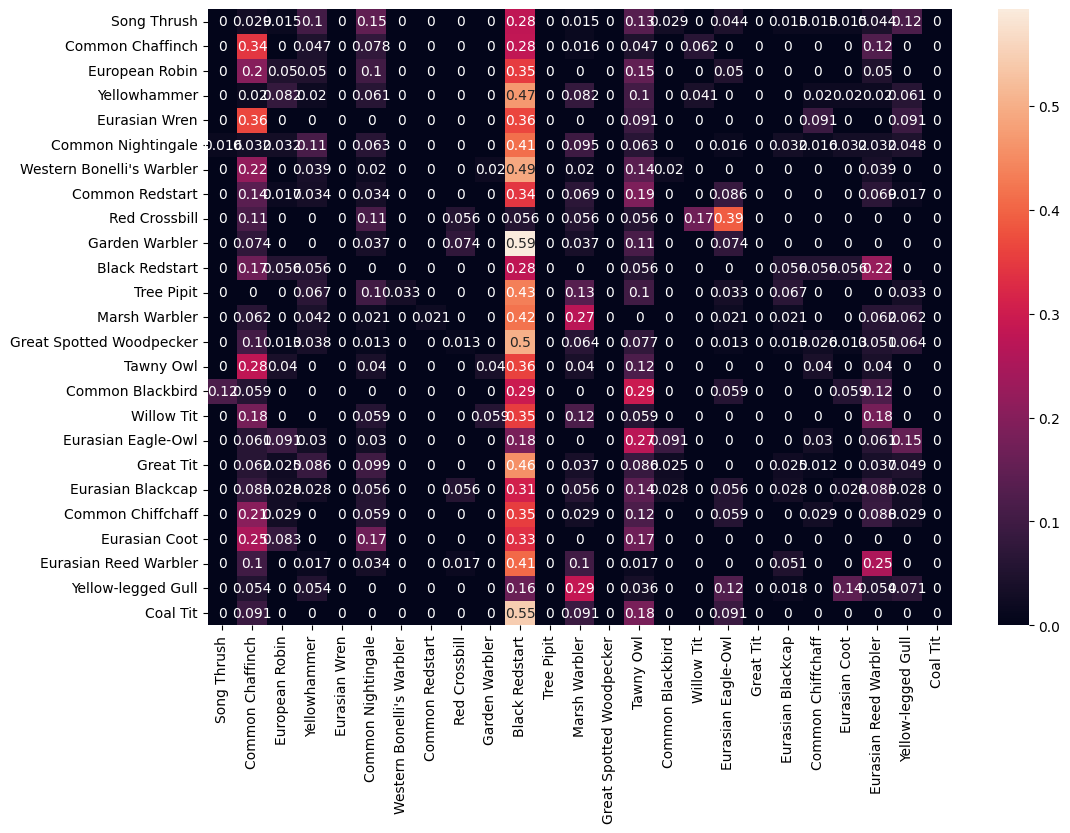

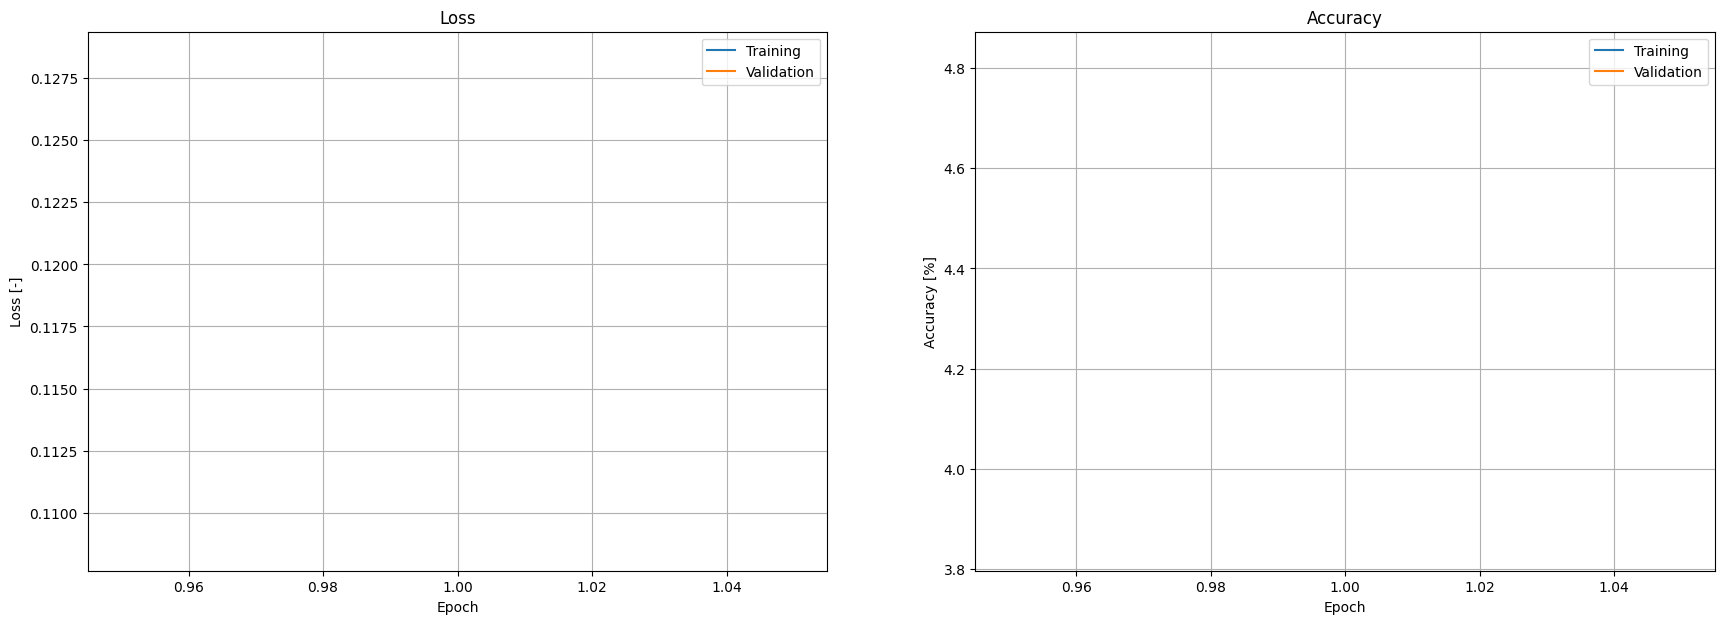

In [44]:
with_replacement = [True, False]
loss_function = ['CrossEntropyLoss', 'LabelSmoothingBCEWithLogitsLoss'] # 'BCEFocalLoss' # 'LabelSmoothingBCEWithLogitsLoss' # 'CrossEntropyLoss' # 'BCEWithLogitsLoss'
augment_audio_train = [True, False]
training_audio_period = [5]

ittt = 0
for replacement_bool in with_replacement:
    for loss_fun in loss_function:
        for augment_aud_bool in augment_audio_train:
            for period in training_audio_period:

                ittt += 1

                print('#########################################################################')
                print('#########################  Running Training {}  #########################'.format(ittt))
                print('#########################################################################')

                CONFIG_GRID = Config()

                exp_name = 'with_replacement_' + str(replacement_bool) + '__loss_function_' + str(loss_fun) + '__augment_audio_train_' + str(augment_aud_bool) + '__training_audio_period_' + str(training_audio_period)

                CONFIG_GRID.with_replacement_train = replacement_bool
                CONFIG_GRID.with_replacement_valid = replacement_bool
                CONFIG_GRID.uniform_sampler = replacement_bool

                CONFIG_GRID.criterion = loss_fun

                CONFIG_GRID.augment_audio_train = augment_aud_bool

                CONFIG_GRID.outpath = os.path.join(CONFIG_GRID.outpath,exp_name)

                CONFIG_GRID.period = period

                factor = period // CONFIG.period

                CONFIG_GRID.train_transforms = torchvision.transforms.Compose([
                            torchaudio.transforms.AmplitudeToDB(),
                            # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            torchvision.transforms.RandomResizedCrop(size=(80*factor,78*factor), scale = (0.75, 1.0), antialias=True), 
                            ])
                
                CONFIG_GRID.val_transforms = torchvision.transforms.Compose([
                            torchaudio.transforms.AmplitudeToDB(),
                            # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            torchvision.transforms.Resize(size=[80*factor,78*factor], antialias=True),
                            # torchvision.transforms.RandomResizedCrop(size=(128, 312), scale = (0.75, 1.0), antialias=True), 
                            ])

                #Train
                main_train(config=CONFIG_GRID, timefolder=False)


                print('#########################################################################')
                print('#########################  Running Test {}  #########################'.format(ittt))
                print('#########################################################################')

                #Test
                CONFIG_GRID.period = CONFIG.period
                run_test(config=CONFIG_GRID)
            

## Kaggle: Zip Directory

In [ ]:
import zipfile
import os
from IPython.display import FileLink

# https://www.kaggle.com/code/hari31416/downloading-file-and-directory-from-kaggle
def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

if CONFIG.run_environment == 'kaggle':
    zip_dir()